<h1 style="font-size: 34px; margin-bottom: 2px; line-height: 0px;">AirBnB - Capstone Project 1 Data Story</h1>
<h3 style="line-height: 2px; font-style: italic;"> Timothy Baney<h3>

* <a href="#intro" style="color: black; text-decoration: none;">Introduction</a>
* <a href="#import" style="color: black; text-decoration: none;">Import Libraries</a>
* <a href="#data-structure" style="color: black; text-decoration: none;">Data Structure</a>
    * <a href="#observ-variable" style="color: black; text-decoration: none;">Observation Variables</a>
    * <a href="#missing-values" style="color: black; text-decoration: none;">Missing Values</a>
    * <a href="#cat-values" style="color: black; text-decoration: none;">Categorical Values</a>
* <a href="#problem-nature" style="color: black; text-decoration: none;">Connections Among Features
    * <a href="#time-series" style="color: black; text-decoration: none;">Time Series</a>
    * <a href="#feature-target" style="color: black; text-decoration: none;">Feature/Target Analysis</a>
* <a href="#summary" style="color: black; text-decoration: none;">Summary</a> 

### <p id="intro" style="margin-bottom: 0px; line-height: 1px;">Introduction</p>
<p>Founded 8 years ago, and similar to its predecessor CouchSurfing, AirBnb is “an online marketplace and hospitality service, enabling people to lease or rent short-term lodging including vacation rentals, apartment rentals, homestays, hostel beds, or hotel rooms.”. AirBnB is located in San Francisco and currently has over three million listings all over the world. The crux of their problem, and the reason they hosted a <a href="https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings" style="text-decoration: none;">competition on Kaggle</a> was in hopes of finding an algorithm that would improve the accuracy of their destination recommendations to first time users. For AirBnB this could have a very positive effect on increasing first time user lodging, and might even improve retention rate for repeat travelers. This notebook is intended to explore the cleansed AirBnB data that I have wrangled to answer questions related to the structure of the data, and about what conclusions can be made from the features of the data related to the target. Data structure questions include: what features belong to every observation, how many missing values does each feature own, and for any feature that is of type category, how many values does that categorical data have. When looking at the nature of the problem, and ways to solve it I will analyze any connections that the data features have with the data target, by using several methods including a time series analysis.</p>

### <p id="import">Import Libraries</p>

In [15]:
import datetime
%matplotlib inline

import pylab
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import datasets, tree
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split

from datetime import datetime as dt

import scipy

import matplotlib.pylab as pylab

ucb = pd.read_csv('clean_airbnb.csv')

full_country_names = {
    'US': 'United States',
    'FR': 'France',
    'DE': 'Denmark',
    'CA': 'Canada',
    'AU': 'Australia',
    'ES': 'Spain',
    'PT': 'Portugal',
    'IT': 'Italy',
    'GB': 'Great Britian',
    'NL': 'Netherlands'
}

pylab.rcParams[ 'figure.figsize' ] = 12 , 5
plt.style.use("fivethirtyeight")

/Users/timothybaney/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### <p id="data-structure">Data Structure - Observation Variables</p>

We will first explore how many features exist for each observation. We subtract one to be sure not to include the target variable.

In [16]:
print('{} Columns'.format(len(ucb.columns) - 1))
print(ucb.dtypes)

35 Columns
country_destination               object
gender                            object
dest_age_pop                     float64
age                              float64
id                                object
date_account_created              object
timestamp_first_active           float64
date_first_booking                object
signup_method                     object
signup_flow                      float64
language                          object
affiliate_channel                 object
affiliate_provider                object
first_affiliate_tracked           object
signup_app                        object
first_device_type                 object
first_browser                     object
lat_destination                  float64
lng_destination                  float64
distance_km                      float64
destination_km2                  float64
destination_language              object
language_levenshtein_distance    float64
actions_total_count              float64
avera

The data has 35 different features, 9 of which being categorical, 12 of which being numerical, and the others being datetimes, or one hot encoding values.

### <p id="missing-values" style="margin-bottom: 0; line-height: 2px;">Data Structure - Missing Values</p>
How many missing values does each feature have? Missing values can include things like NaN "Not a number", Null, or even 0 for features such as age, where 0 is impossible. We will drop any one hot encoding boolean values (1 or a 0 for if an observation fits a category or not).

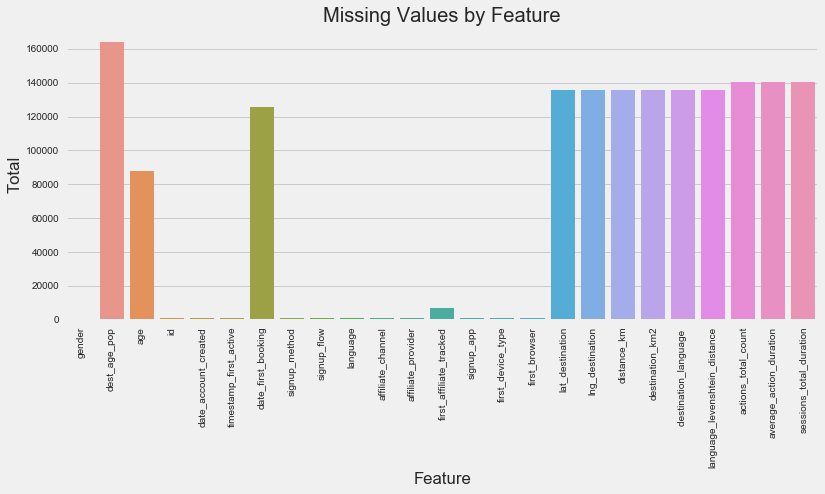

In [17]:
def convertToNull(row):
    if row['age'] == 0:
        return np.nan
    else:
        return row['age']
    
ucb_features = ucb.copy()
ucb_features['age'] = ucb_features.apply(lambda x: convertToNull(x), axis=1)

ucb_features = ucb_features.drop(['country_destination', 'US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT'], axis=1)

features = ucb_features.columns
feature_nulls = [ucb_features[col].isnull().sum() for col in ucb_features.columns]
fnulls = sns.barplot(features, feature_nulls)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Total')
plt.title('Missing Values by Feature')
plt.show()

There are several missing values for country-related features like: latitude, longitude, distance_km2, destination, age, population, destination_language, and destination_km2. This is because of the target class 'NDF' or 'No Destination found'. This is a user who never booked a trip. This is also a good explanation for why the number of null or missing values for date_first_booking is so high. When merging users and session data, a left join was used in favor of the users dataset which means that any user whose id couldn't be found in a session remained, but received null values for session info. This is why there are so many null values for actions total count, average action durations, and sessions total duration. Unfortunately age, a feature with promising insights also has a lot of null values. Any value for age that is a zero is also considered to be a null value in this case. This simply means that a lot of users don't include their age when signing up. To remedy this, I will first remove any user who never booked a trip. When building charts with age, I will remove any users with a null age for clearer distributions , but will rejoin all the users without an age back into the data, giving them the average age of all users.

### Remove NDF and Other destination values

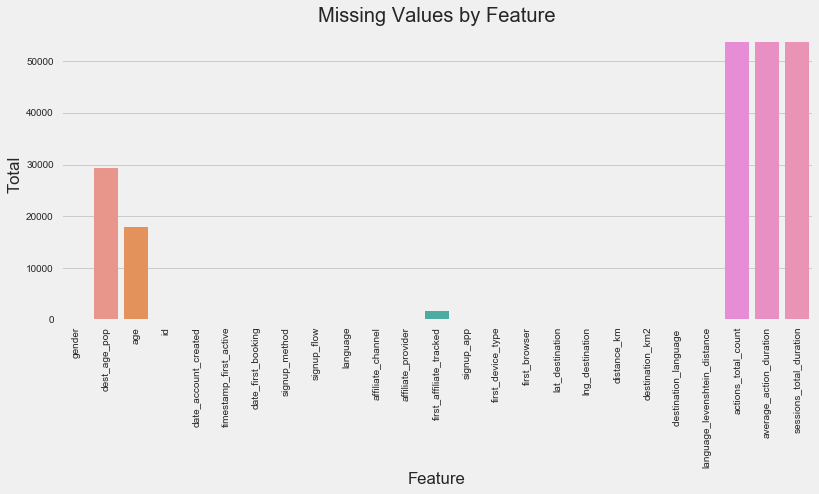

In [18]:
ucb = ucb[(ucb['country_destination'] != 'NDF') & (ucb['country_destination'] != 'other')]
ucb = ucb[~ucb['id'].isnull()]

ucb_features = ucb.copy()
ucb_features['age'] = ucb_features.apply(lambda x: convertToNull(x), axis=1)

ucb_features = ucb_features.drop(['country_destination', 'US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT'], axis=1)

features = ucb_features.columns
feature_nulls = [ucb_features[col].isnull().sum() for col in ucb_features.columns]
fnulls = sns.barplot(features, feature_nulls)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Total')
plt.title('Missing Values by Feature')
plt.show()

### <p id="cat-values" style="margin-bottom: 0; line-height: 2px;">Data Structure - Categorical Values</p>
How many unique values does each feature that takes categorical values have?

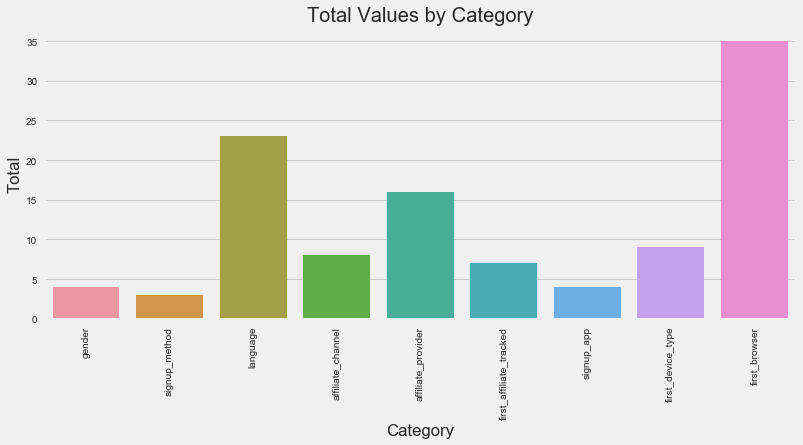

In [19]:
ucb_categories = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

feature_values = [ucb[col].value_counts().count() for col in ucb_categories]
fnulls = sns.barplot(ucb_categories, feature_values)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Total')
plt.title('Total Values by Category')
plt.show()

It appears as though most categorical features have less than ten values, the only exceptions being language, affiliate provider, and the first browser used when going to AirBnB.

### <p id="problem-nature">Connections Among Features</p>
As mentioned above, this project is related to a Kaggle competition for AirBnB. AirBnB hosted the competition because they were looking for an algorithm that would help them improve their destination recommendations to new users. Based on this, the crux of the issue is to find some connection between a users' features like age, gender, and browser to what country their first booking was to. If highly accurate predictions can be made based on this information, it will improve the relevance of AirBnbB's country recommendation. In this section, we will look at feature connections with several differen plot including bar charts, line charts "for time series analysis", and box plots.

### <p id="time-series" style="margin-bottom: 0; line-height: 2px;">Time Series</p>

Over time, is it possible to see any trends between the country destination and other features of the user? We will explore this by first looking at the total number of visitors to each country over a four-year time span, in one-month periods.

In [20]:
ucb_w_reindex = ucb.copy()
ucb_w_reindex['date_account_created'] = pd.to_datetime(ucb['date_account_created'])
ucb_w_reindex = ucb_w_reindex.sort_values('date_account_created', ascending=False)
ucb_w_reindex = ucb_w_reindex.set_index('date_account_created')

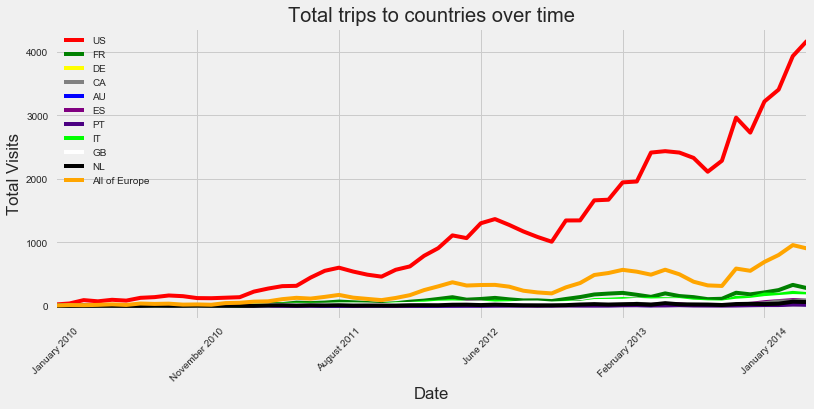

In [21]:
def isEurope(row):
    if row['country_destination'] in ['NL', 'FR', 'DE', 'ES', 'PT', 'GB', 'IT']:
        return 1
    else:
        return 0

    country
    
ucb_w_reindex['eur'] = ucb_w_reindex.apply(lambda x: isEurope(x), axis=1)

labels = ['January 2010', 'November 2010', 'August 2011', 'June 2012', 'February 2013', 'January 2014']
colors = ['red', 'green', 'yellow', 'gray', 'blue', 'purple', 'indigo', 'lime', 'white', 'black']

for index, country in enumerate(full_country_names):
    total_ot = ucb_w_reindex[country].resample('M').sum()
    sns.tsplot(data=total_ot, color=colors[index], legend=True, condition=country)

eur_m_ot = ucb_w_reindex.eur.resample('M').sum()
ax = sns.tsplot(data=eur_m_ot, color='orange', legend=True, condition='All of Europe')

ax.set_xticklabels(labels)
plt.title('Total trips to countries over time')
plt.xticks(rotation=45)
plt.ylabel('Total Visits')
plt.xlabel('Date')

plt.legend()
plt.show()

For most European countries, the total number of visitors over a span of 4 years is not rising very much, compared to the number of visitors to the United States where total visitors over that same 4 years is skyrocketing. There are a few explanations for this however. Since the USA is much like Europe in that it is a union of sovereign states, and since most people that visit one country in Europe are likely to visit surrounding ones as well, I grouped all the European countries together as simply ‘Europe’ and plotted its total visitors over time. Even this showed only a modest improvement however.
<br>
<br>
<br>
<br>
Could some connection between the future of major user features like age and gender help to make a more accurate prediction of where what country the user is most likely to visit? I wanted to answer this by using more line graphs to show the trend of average age, and average number of males/females for each country over time.

/Users/timothybaney/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: 
.resample() is now a deferred operation
You called rolling(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


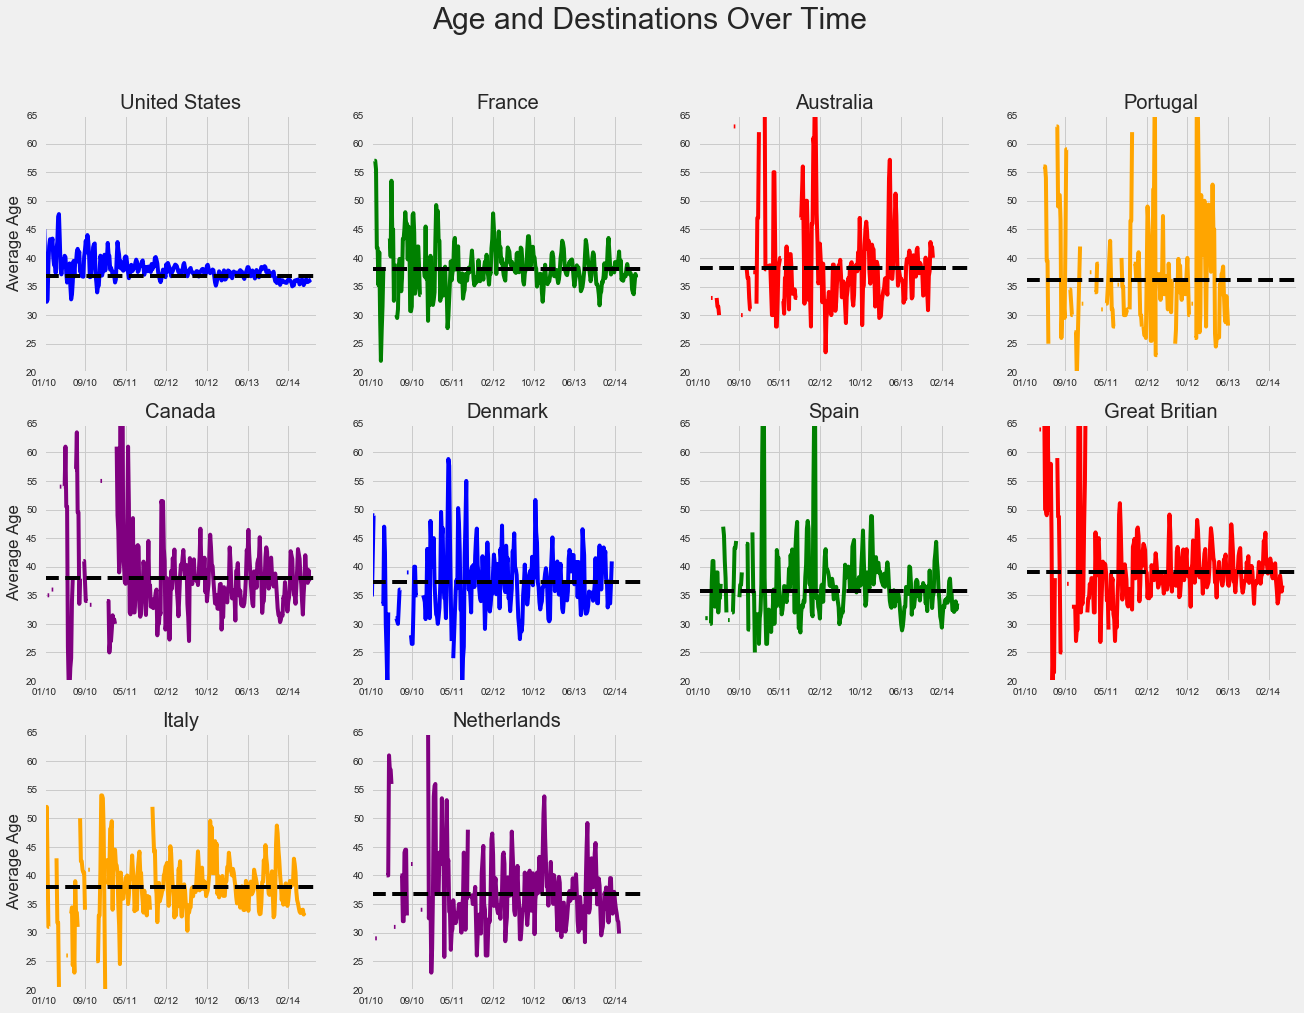

In [22]:
ucb_w_reindex_age = ucb_w_reindex[np.isfinite(ucb_w_reindex['age'])]
ucb_w_reindex_age = ucb_w_reindex_age.loc[ucb_w_reindex_age['age'] < 120]

def ageSeries(country):
    return ucb_w_reindex_age.loc[ucb_w_reindex_age['country_destination'] == country].age.fillna(value=30).resample('5d').rolling(window=3, min_periods=1).mean()

def avgAge(country):
    return ucb_w_reindex_age.loc[ucb_w_reindex_age['country_destination'] == country].age.mean()

num_plots = 10
fig, axes = plt.subplots(3, 4,figsize=(20, 15))
labels = ["01/10", "09/10", "05/11", "02/12", "10/12", "06/13", "02/14"]

list_of_dfs = [{'country': item, 'age': ageSeries(item), 'avgAge': avgAge(item)} for item in ['US', 'FR', 'AU', 'PT', 'CA', 'DE', 'ES', 'GB', 'IT', 'NL']]

colors = ['blue', 'green', 'red', 'orange', 'purple', 'blue', 'green', 'red', 'orange', 'purple']
col, row, loop = (0, 0, 0)
for obj in list_of_dfs:
    row = math.floor(loop/4)
    
    sns.tsplot(data=obj['age'], color=colors[loop], ax=axes[row, col])
    axes[row, col].set_title('{}'.format(full_country_names[obj['country']]))
    axes[row, col].axhline(obj['avgAge'], color='black', linestyle='dashed', linewidth=4)
    axes[row, col].set(ylim=(20, 65))
    axes[row, col].set_xticklabels(labels, rotation=0)
    axes[row, col].set_xlim(0, 335)
    
    if col == 0:
        axes[row, col].set(ylabel='Average Age')
    
    if row == 2:
        if col > 1:
            axes[row, col].set_axis_off()
    
    col += 1
    loop += 1
    
    if col == 4:
        col = 0
        
fig.delaxes(axes[2, 2])
fig.delaxes(axes[2, 3])
    
fig.suptitle('Age and Destinations Over Time', fontsize=30)
plt.show()

From the time series above, we can draw a few conclusions. By looking at the average age per user for each country, we can see that for the United States, and the Netherlands, they are starting to attract younger users, and that the average age in general for visitors to Australia is noteably higher than other countries.

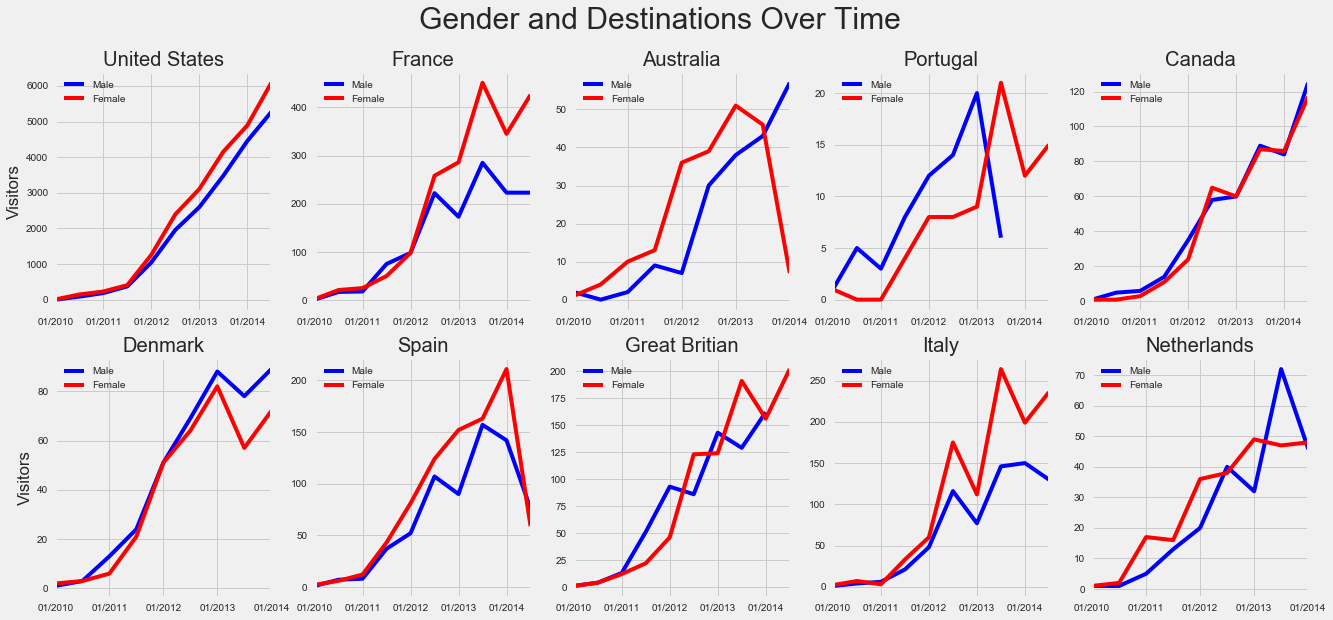

In [23]:
ucb_w_reindex_gender = ucb_w_reindex.copy()

def genderSeries(country, gender):
    return ucb_w_reindex_gender.loc[(ucb_w_reindex_gender['country_destination'] == country) & (ucb_w_reindex_gender['gender'] == gender)]['gender'].fillna(method='ffill').resample('6M').count()

list_of_dfs = [{'country': item, 'dmale': genderSeries(item, 'male'), 'dfem': genderSeries(item, 'female')} for item in ['US', 'FR', 'AU', 'PT', 'CA', 'DE', 'ES', 'GB', 'IT', 'NL']]

num_plots = 10
fig, axes = plt.subplots(2,5,figsize=(20,9))
labels = ["01/2010", "01/2011", "01/2012", "01/2013", "01/2014"]

col, row, loop = (0, 0, 0)
for obj in list_of_dfs:
    row = math.floor(loop/5)
    
    sns.tsplot(data=obj['dmale'], color='blue', ax=axes[row, col], legend=True, condition='Male')
    sns.tsplot(data=obj['dfem'], color='red', ax=axes[row, col], legend=True, condition='Female')
    axes[row, col].set_title('{}'.format(full_country_names[obj['country']]))
    axes[row, col].set_xticklabels(labels, rotation=0)
    
    if col == 0:
        axes[row, col].set(ylabel='Visitors')
        
    col += 1
    loop += 1
    
    if col == 5:
        col = 0
        
fig.suptitle('Gender and Destinations Over Time', fontsize=30)
plt.legend()
plt.show()

In regards to the total number of men vs women booking trips over time for each country, they grow or fall about equally with each other except for Italy, and France, where the the number of males is leveling off, but female visitors continue to grow. Perhaps this is due to Italy and France having a romantic air to its charm that women are attracted to. For Australia, it is just the opposite though as the number of females visiting the country seems to be dropping sharply, whereas the amount of men booking trips there is continuing to grow. Countries in Oceania, like Australia, New Zealand, and Tasmania have more extreme elements to it like living conditions, and extreme sports such as bungee jumping, and rugby that may attract males more than females. 

### <p id="feature-target" style="margin-bottom: 0; line-height: 2px;">Feature/Target Analysis</p>

Lets now look to see if there are any direct connection, or assumptions we can make between features, and the country destination chosen. The features I will be looking at are the account creation date, the date of the user's first booking, age by gender/country, browser usage, session action, and session duration time, as well as a user's language preference vs destination language.

In [24]:
ucb = ucb.dropna(subset=['date_account_created'])

In [25]:
def getMonth(row, option='create'):
    if option == 'create':
        if row['date_account_created'] != 'nan':
            month = int(str(row['date_account_created']).split('-')[1])
        else:
            month = np.nan
    else:
        if row['date_first_booking'] != 'nan':
            try:
                month = int(str(row['date_first_booking']).split('-')[1])
            except:
                return
        else:
            month = np.nan
        
    return month

def getSeason(row):
    seasons = {
        '01': 'Winter',
        '02': 'Winter',
        '03': 'Spring',
        '04': 'Spring',
        '05': 'Spring',
        '06': 'Summer',
        '07': 'Summer',
        '08': 'Summer',
        '09': 'Autumn',
        '10': 'Autumn',
        '11': 'Autumn',
        '12': 'Winter'
    }
    
    try:
        return seasons[str(row['date_first_booking']).split('-')[1]]
    except:
        return np.nan
    
ucb['month'] = ucb.apply(lambda x: getMonth(x), axis=1)
ucb['month_booked'] = ucb.apply(lambda x: getMonth(x, 'booking'), axis=1)

ucb['season_booked'] = ucb.apply(lambda x: getSeason(x), axis=1)

### Feature/Target Analysis - Account Creation/Bookings by Month

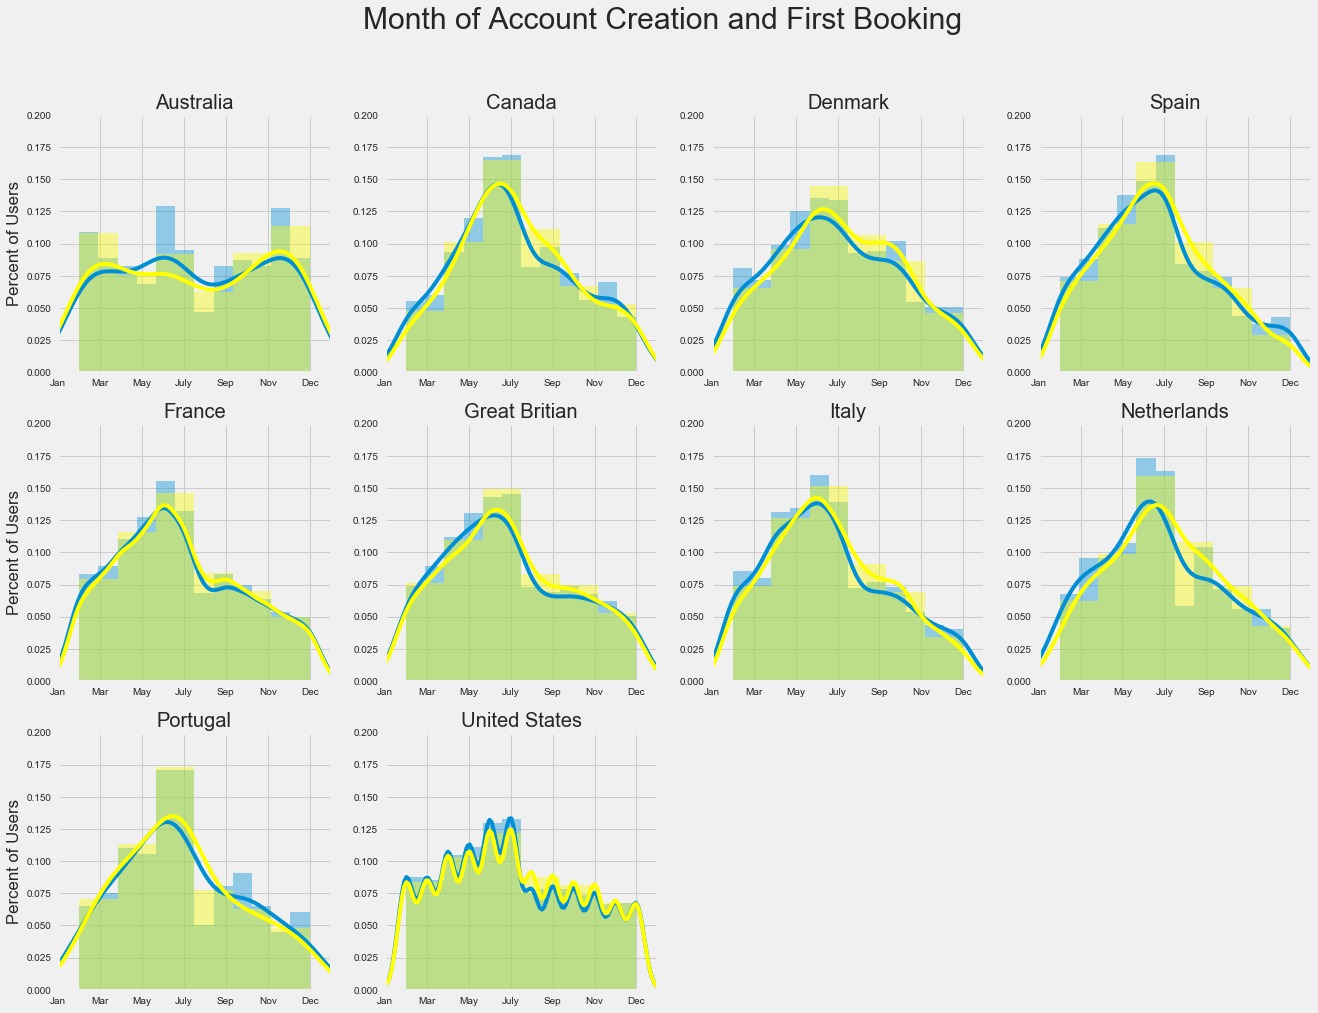

In [27]:
num_plots = 10
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

month_labels = ['']

col, row, loop = (0, 0, 0)
# iterate through all axes and create a violin plot
for i in range(num_plots):
    row = math.floor(loop/4)

    data = ucb[ucb.country_destination.isin(buckets(i))]
    x = data['month']
        
    ax_curr = axes[row, col]
    
    title = full_country_names[buckets(i)[0]]
    
    sns.distplot(x, bins=12, ax=ax_curr)
    ax_curr.set_title(title)
    ax_curr.set_ylim([0, .2])
    ax_curr.set_xlim([0, 13])
    
    col += 1
    loop += 1
    
    if col == 4:
        col = 0
        
col, row, loop = (0, 0, 0)
for i in range(num_plots):
    row = math.floor(loop/4)

    data = ucb[ucb.country_destination.isin(buckets(i))]
    x = data['month_booked']
    
    objects = ('Jan', 'Mar', 'May', 'July', 'Sep', 'Nov', 'Dec')
    y_pos = np.arange(len(objects))
    
    ax_curr = axes[row, col]
    
    title = full_country_names[buckets(i)[0]]
    
    sns.distplot(x, bins=6, ax=ax_curr, color="yellow")
    ax_curr.set_title(title)
    
    if col == 0:
        ax_curr.set_ylabel('Percent of Users')
        
    ax_curr.set_ylim([0, .2])
    ax_curr.set_xlim([0, 13])
    ax_curr.set_xlabel('')

    ax_curr.set_xticklabels(objects, rotation=0)
    
    col += 1
    loop += 1
    
    if col == 4:
        col = 0

fig.delaxes(axes[2, 2])
fig.delaxes(axes[2, 3])
        
fig.suptitle('Month of Account Creation and First Booking', fontsize=30)
plt.show()

Seen above are histogram plots. A histogram is a graphical display of data using bars "bins" of different heights. We separate all the users by their account creation date, and the date of their first booking. If the date falls into a certain month, like January, it will be added to that month bar. The curves overlaying the graphs are meant to show a smooth distribution of the bins. The blue is for account creation date, the yellow is for the date of the users first booking, and the green is the overlap of account creation date, and the first booking date. By looking at the histograms shown, we can make two clear observations. By overlapping the month the account was created, and the month the user booked their first trip, we can see that the time the user books their first trip will typically not be more than 2 months after they create their account. Two being that users are far less likely to book trips anytime in the winter. This can be made clearer by looking at the USA, and Australia. The number of visitors to Australia is more distributed in the months of November through February than any other country. This is most likely due to it being in the southern hemisphere where their seasons are inverted. The USA is very large a geographically located where it enjoys a diverse number of climates (Warm and humid in the south east, warm and dry in the southwest, and cold and dry in the northern Midwest, and cold and humid in the northeast, and northwest), and this may be the reason it has a flatter, more equal distribution compared to other countries farther north, and closer together in Europe.

### Feature/Target Analysis - Bookings by Season

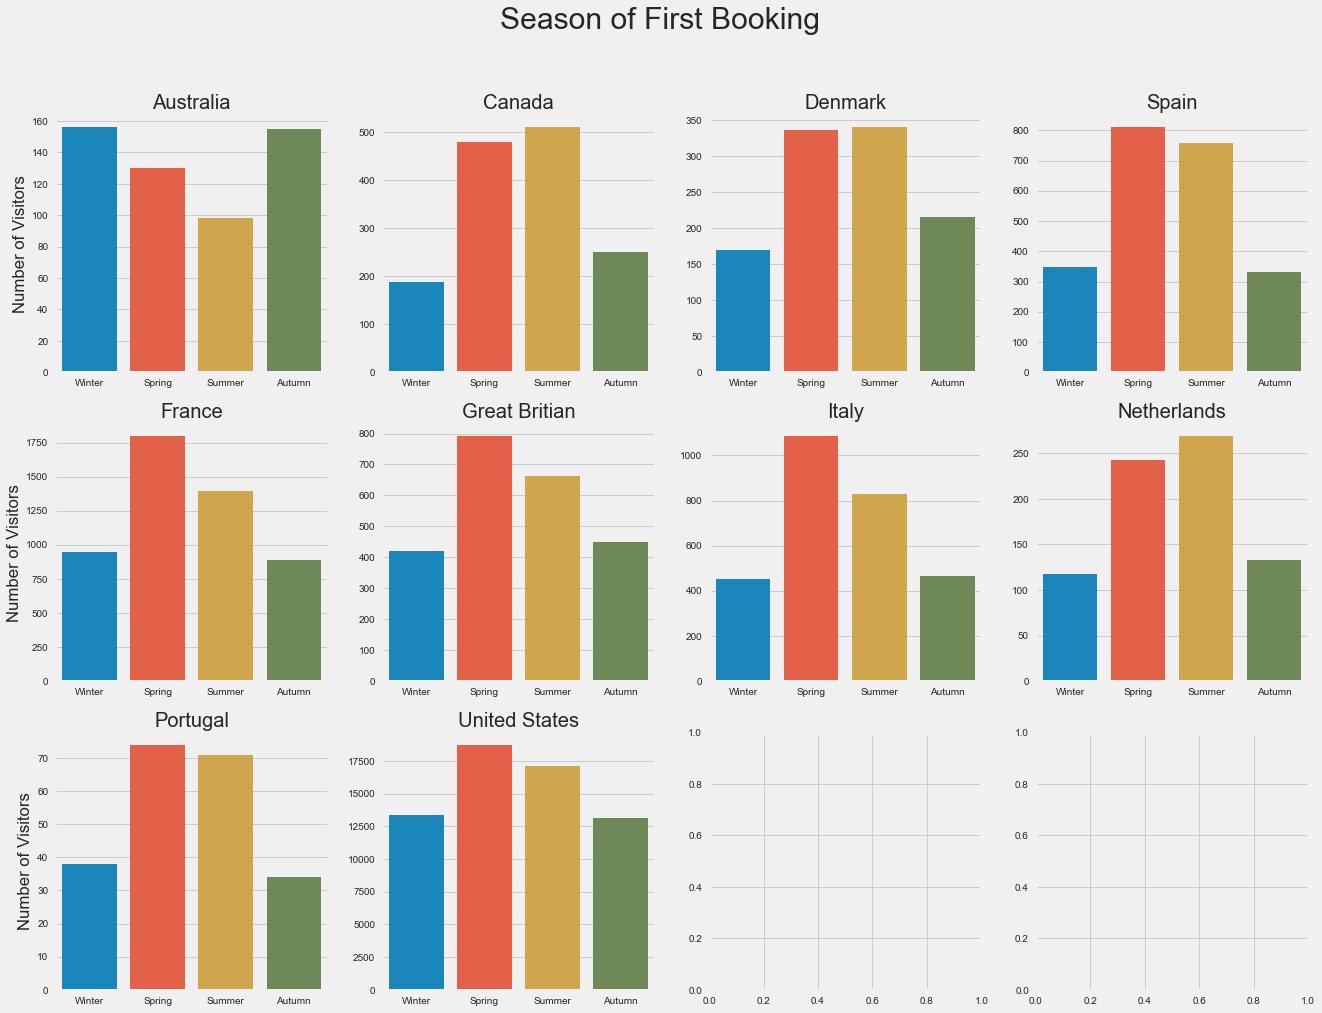

In [61]:
season_x = ['Winter', 'Spring', 'Summer', 'Autumn']

num_plots = 10
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

col, row, loop = (0, 0, 0)
for i in range(num_plots):
    row = math.floor(loop/4)

    data = ucb[ucb.country_destination.isin(buckets(i))]
    
    season_y = [data[data['season_booked'] == season]['id'].count() for season in season_x]
        
    ax_curr = axes[row, col]
    
    title = full_country_names[buckets(i)[0]]
    
    sns.barplot(season_x, season_y, ax=ax_curr)
    ax_curr.set_title(title)
    
    if col == 0:
        ax_curr.set_ylabel('Number of Visitors')
        
    ax_curr.set_xlabel('')
    
    col += 1
    loop += 1
    
    if col == 4:
        col = 0

fig.suptitle('Season of First Booking', fontsize=30)
plt.show()

To strengthen our point about visitors only traveling during certain times of year, I created histograms for each season rather than for each month. A season is defined as the three month period from a solstice/equinox to the next solstice/equinox. For example Winter is defined by all the observations in the data from December 21st to March 21st. We can also make some additional discoveries. For most countries in Europe, the number of visitors in the Spring are actually greater than the visitors in the Summer.
<br> 
<br>
<br>
### Feature/Target Analysis - Age Distribution by Country/Gender

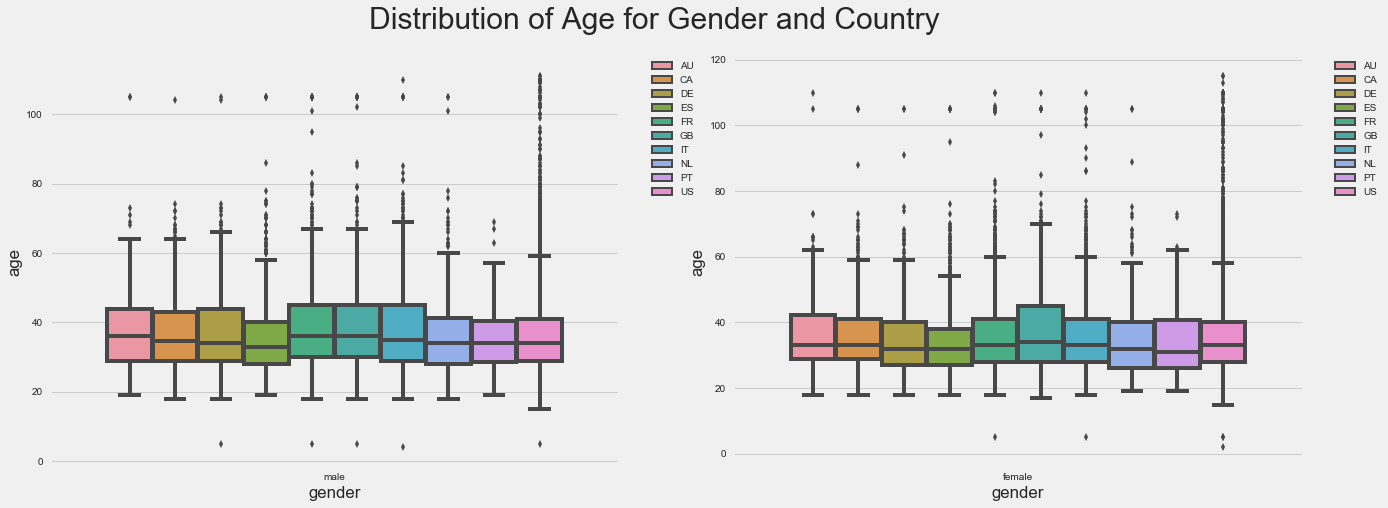

In [62]:
ucb = ucb[np.isfinite(ucb['age'])]
ucb = ucb.loc[(ucb['age'] < 120) & (ucb['age'] > 0)]
ucb = ucb.loc[(ucb['gender'] == 'male') | (ucb['gender'] == 'female')]

# num_plots = 10
fig, axes = plt.subplots(1, 2,figsize=(20, 7))

male_ucb = ucb.loc[ucb['gender'] == 'male']
female_ucb = ucb.loc[ucb['gender'] == 'female']

sns.boxplot(x="gender", y="age", data=male_ucb, hue='country_destination', ax=axes[0])
sns.boxplot(x="gender", y="age", data=female_ucb, hue='country_destination', ax=axes[1])

axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.suptitle('Distribution of Age for Gender and Country', fontsize=30)
plt.show()

The colored box is the mode "the line in the middle of the box", the 1st and 3rd quartiles "25 percent of rows below, and above them mode", and the min and max "horizontal line at end of whiskers". Anything outside the whiskers are outliers. A couple discoveries were that the range between the 1st and second quartiles for Spain was very small, and consisted of the youngest ages for any other country. The range between quartiles for Great Britain was much wider, and for a much older crowd. Younger people will tend to want to ‘go off the unbeaten track’, and find adventure more often than older travelers who may fall into tourist traps more often. Great Britain is a well-known, and more predictable travel destination than Spain, but this is just personal speculation, and more research would be needed to ascertain this. 
<br>
<br>
<br>
The world has evolved at an exponential rate due to the invention of the world wide web by Tim Berners Lee in 1989. Today there now exists a wide list of different internet browsers. Could there be some link between what browser a user is on while in the AirBnB site versus where they will make a trip to?

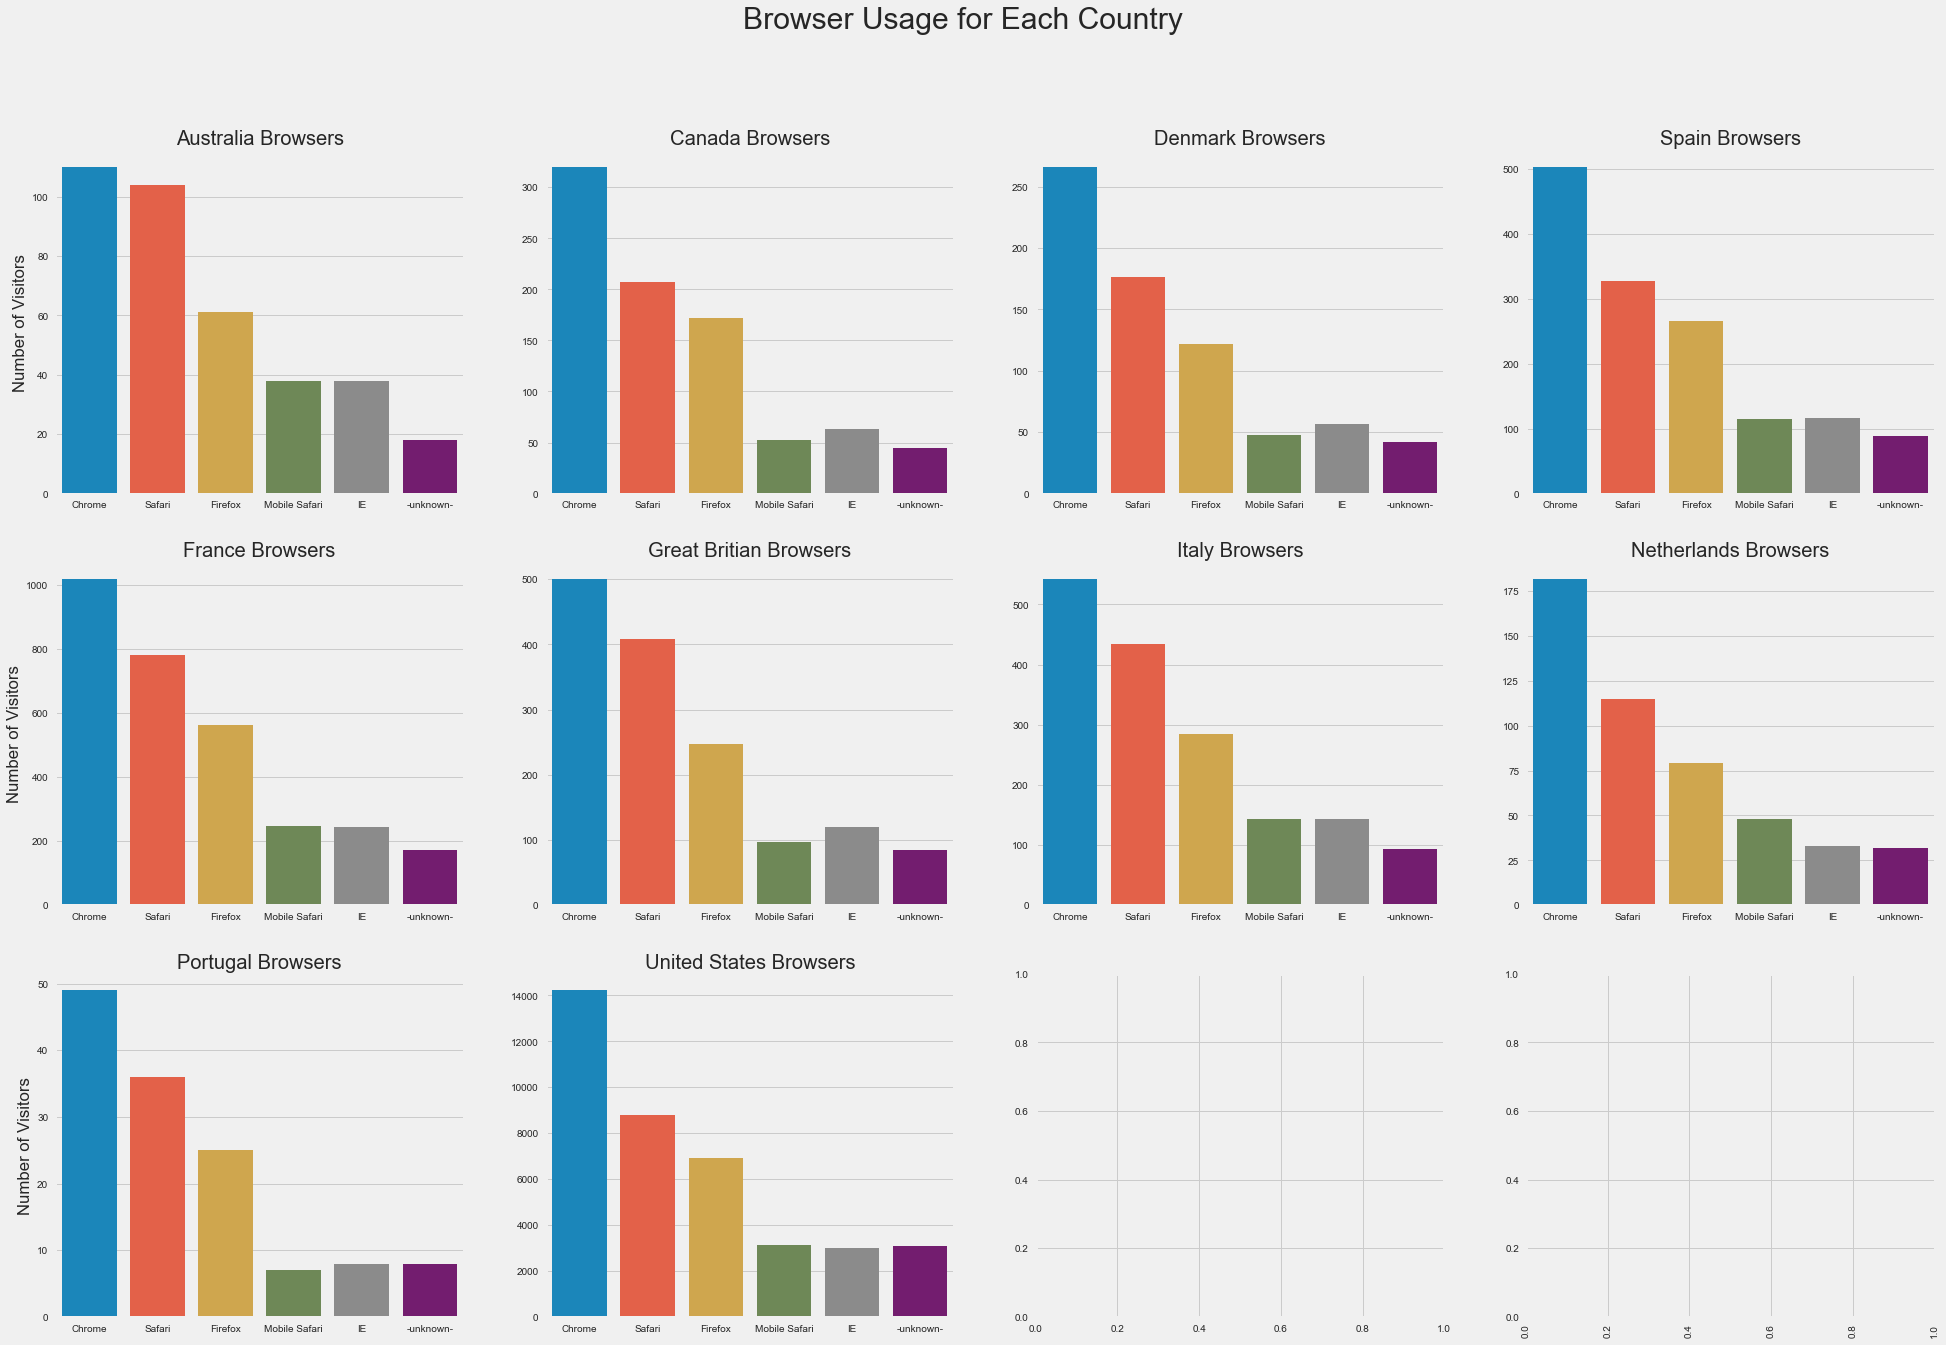

In [63]:
small_browsers = ['AOL Explorer', 'Chromium', 'Silk', 'BlackBerry Browser', 'Apple Mail', 'RockMelt', 'Mobile Firefox', 'Maxthon',
'IceWeasel', 'Camino', 'Sogou Explorer', 'Iron', 'CoolNovo', 'SiteKiosk', 'Pale Moon', 'TheWorld Browser', 'NetNewsWire',
'Mozilla', 'CometBird', 'Opera Mini', 'TenFourFox', 'Stainless', 'IE Mobile', 'Android Browser', 'Chrome Mobile', 'Opera', 'Avant Browser',
'Yandex.Browser', 'Comodo Dragon', 'SlimBrowser', 'PS Vita browser', 'Opera Mobile', 'wOSBrowser', 'SeaMonkey', 'Crazy Browser',
'OmniWeb', 'Flock', 'Outlook 2007', 'Arora', 'Conkeror', 'IceDragon']

for bwsr in small_browsers:
    ucb = ucb.loc[ucb['first_browser'] != bwsr]

fig, axes = plt.subplots(3, 4, figsize=(30, 20))

def totalBrowsersByCountry(country, browser, data):
    return data.loc[(data['country_destination'] == country) & (data['first_browser'] == browser)]['first_browser'].count()

browsers = ucb['first_browser'].value_counts().index.tolist()

col, row, loop = (0, 0, 0)
for i in range(num_plots):
    row = math.floor(loop/4)

    # Get country data for only that country US, FR, IT
    data = ucb[ucb.country_destination.isin(buckets(i))] #<= USA SQUARE
    country = buckets(i)[0]
    
    browser_counts = [totalBrowsersByCountry(country, x, data) for x in browsers]
            
    ax_curr = axes[row, col]
    
    title = full_country_names[country]
    
    bwsr = sns.barplot(browsers, browser_counts, ax=ax_curr)
    bwsr.set_title('{} Browsers'.format(title))
    plt.xticks(rotation=90)
    
    if col == 0:
        ax_curr.set_ylabel('Number of Visitors')
        
    ax_curr.set_xlabel('')
    
    col += 1
    loop += 1
    
    if col == 4:
        col = 0

fig.suptitle('Browser Usage for Each Country', fontsize=30)
plt.show()

By looking at the total number of browsers by country, we can see that Chrome is the most widely used browser for any country visited. Safari comes in second, follwed by firefox. Great Britian, France, and Australia have a higher percentage of firefox user visitors than other countries.
<br>
<br>
<br>
<br>
When signing up for an account, AirBnB will ask you for a language preference. Could the percentage of users who go to countries whose native language matches their language preference be considerable?

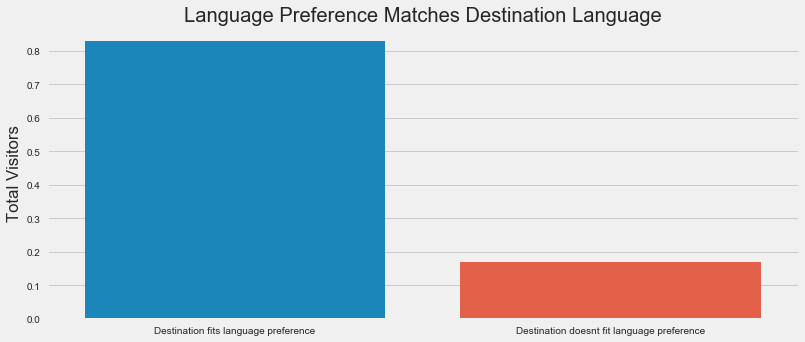

In [64]:
lang_dict = {'en': 'eng', 'fr': 'fra', 'it': 'ita', 'es': 'spa', 'de': 'deu', 'nl': 'nld', 'pt': 'por'}

def convertLang(row):
    if row['language'] in lang_dict:
        return lang_dict[row['language']]
    else:
        return row['language']
    
ucb['language'] = ucb.apply(lambda x: convertLang(x), axis=1)

def langPrefMatch(row):
    if row['language'] == row['destination_language ']:
        return 1
    else:
        return 0
    
ucb['lang_match'] = ucb.apply(lambda x: langPrefMatch(x), axis=1)

lang_pref_match = ucb.loc[ucb['lang_match'] == 1]['lang_match'].count()/ucb['lang_match'].count()
lang_pref_no_match = ucb.loc[ucb['lang_match'] == 0]['lang_match'].count()/ucb['lang_match'].count()

x = ['Destination fits language preference', 'Destination doesnt fit language preference']
y = [lang_pref_match, lang_pref_no_match]
sns.barplot(x, y)

plt.title('Language Preference Matches Destination Language')
plt.ylabel('Total Visitors')
plt.show()

By creating a new feature of the dataset that is of type Boolean, simply showing whether the user’s language preference matches their destinations native language, we see perhaps the most statistically, and practically significant connection yet. This is most likely something AirBnB uses in their decision of what countries to recommend to its users, but it will still be a great help for our predictions in the future. 
<br>
<br>
<br>
<br>
Before booking a trip, a user will usually spend a considerable time navigating through the site, and acting on different site features. They could update their profile, search for a country, and view the results, refine the filters, etc. Could we see any relationship between the type of activity of a user on AirBnB compared to what country they booked a trip to?

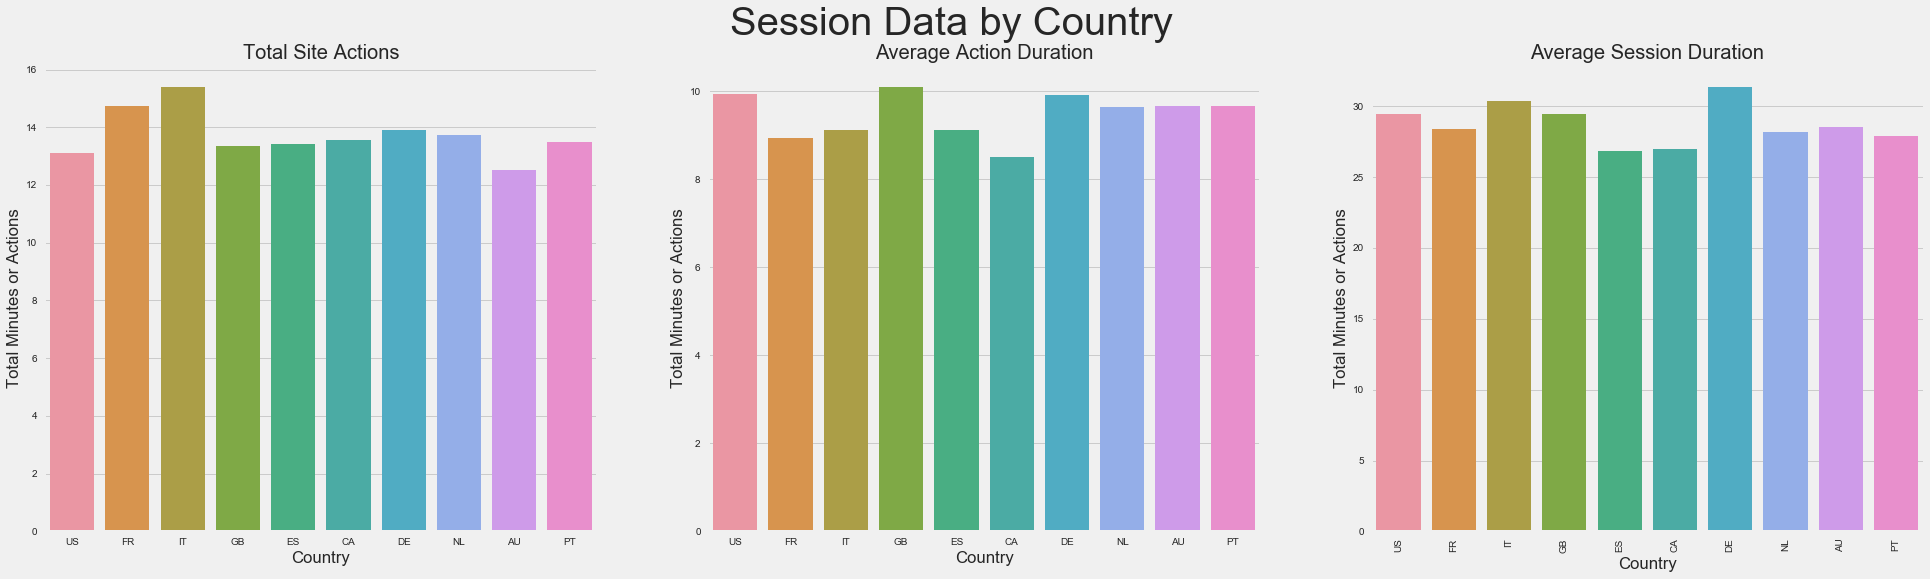

In [132]:
fig, axes = plt.subplots(1, 3,figsize=(30, 8))

countries = ucb.country_destination.value_counts().index.tolist()

def getAvg(country, feature):
    return ucb.loc[ucb['country_destination'] == country][feature].mean()

tot_act = [getAvg(country, 'actions_total_count') for country in countries]
avg_action_dur = [getAvg(country, 'average_action_duration') for country in countries]
avg_session_dur = [getAvg(country, 'sessions_total_duration') for country in countries]

bwsr = sns.barplot(countries, tot_act, ax=axes[0])
bwsr.set_title('Total Site Actions')
bwsr.set(xlabel='Country', ylabel='Total Minutes or Actions')
plt.xticks(rotation=90)

bwsr = sns.barplot(countries, avg_action_dur, ax=axes[1])
bwsr.set_title('Average Action Duration')
bwsr.set(xlabel='Country', ylabel='Total Minutes or Actions')
plt.xticks(rotation=90)

bwsr = sns.barplot(countries, avg_session_dur, ax=axes[2])
bwsr.set_title('Average Session Duration')
bwsr.set(xlabel='Country', ylabel='Total Minutes or Actions')
plt.xticks(rotation=90)

fig.suptitle('Session Data by Country', fontsize=40)
plt.xlabel('Country')
plt.show()

By looking at the session data, we can see the variance in the average session time, average action time, and average total actions by country. These actions are things like viewing one's profile, searching through room listings, editing one's profile, etc. We can see that for the average session duration, there is a difference of 5 minutes between the countries with the largest, and shortest duration. The biggest difference for the average action duration between countries is only a minute, and the total actions range between 12, and 15. Could the difference in session time really play a role in what country someone might visit? Perhaps someone who is more decisive, and spends less time on the site will go to a non european country, because someone going to europe might have to decide between a lot more options than the ones in North America.

### Total Countries Overall

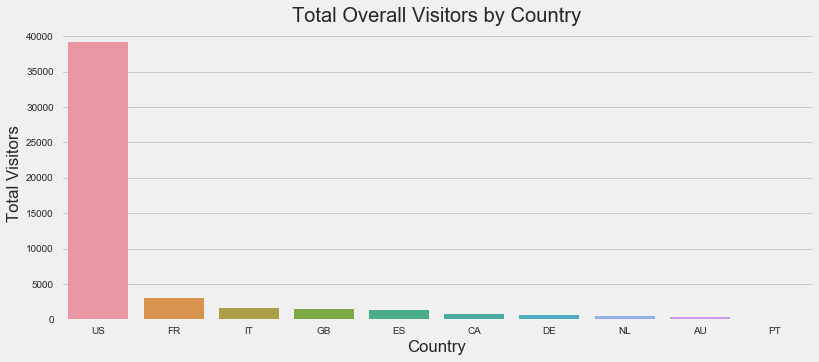

In [297]:
countries = ['AU', 'FR', 'US', 'IT', 'PT', 'ES', 'NL', 'DE', 'CA', 'GB']
occurences = sorted([{'name': country, 'total': ucb[ucb['country_destination'] == country]['id'].count()} for country in countries], key=lambda x: x['total'], reverse=True)

occurences
x = [obj['name'] for obj in occurences]
y = [obj['total'] for obj in occurences]

sns.barplot(x, y)
plt.ylabel('Total Visitors')
plt.xlabel('Country')
plt.title('Total Overall Visitors by Country')
plt.show()

### Inferential Statistics

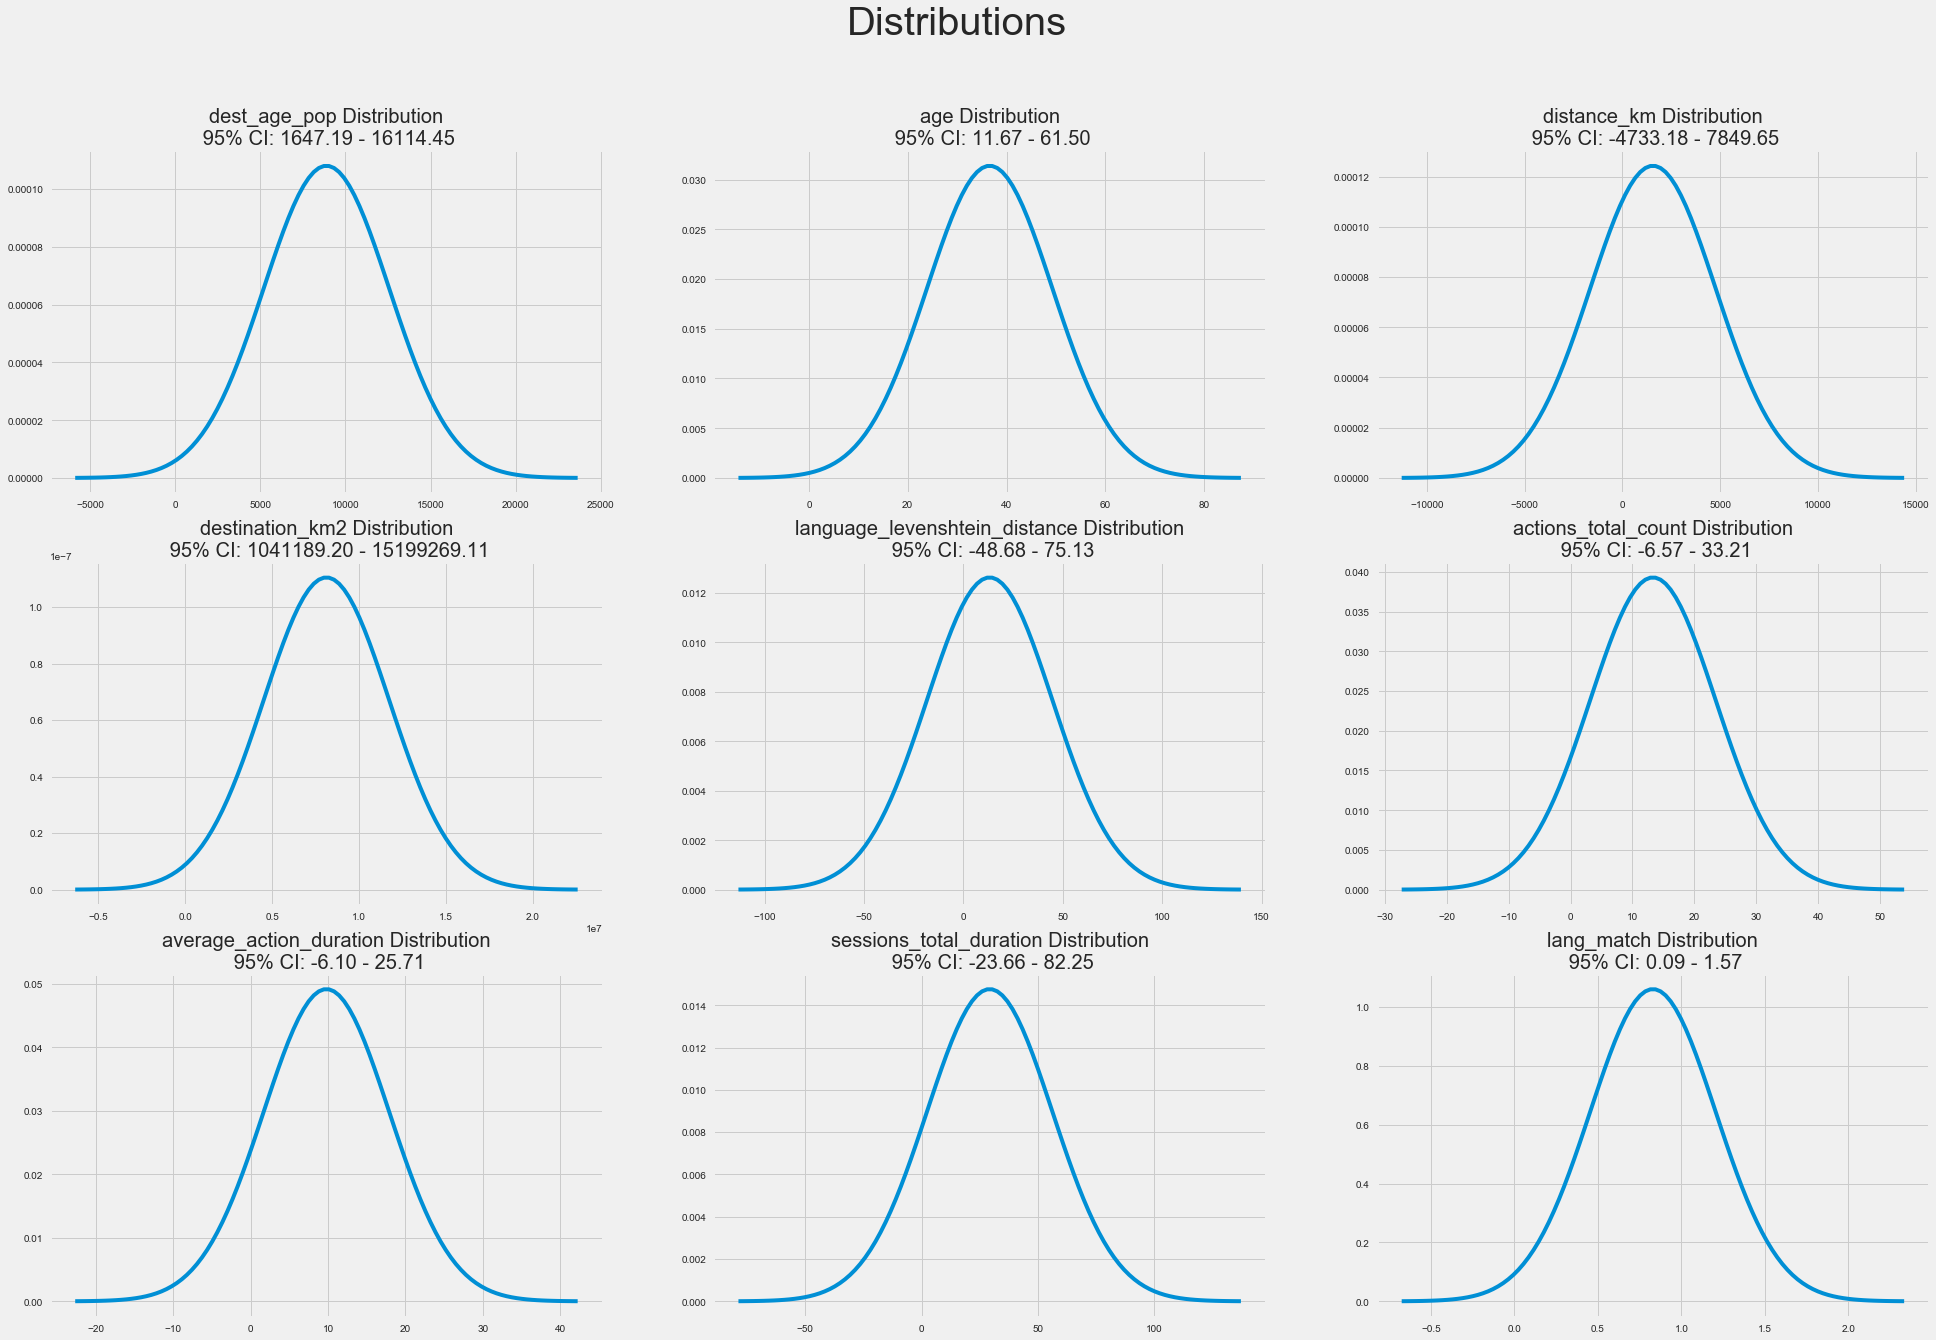

In [298]:
infer_ucb = ucb.copy()
infer_ucb = infer_ucb.drop('id', axis=1)
infer_ucb = infer_ucb.drop('country_destination', axis=1)
infer_ucb = infer_ucb.drop(['month_booked', 'month', 'lat_destination', 'lng_destination', 'timestamp_first_active', 'signup_flow', 'date_account_created', 'US', 'FR', 'IT', 'ES', 'DE', 'GB', 'CA', 'AU', 'NL', 'PT'], axis=1)

def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

def summary_stats(sample_stats, z_score):
    z_score_value = sample_stats.std() * z_score
    return '{} Distribution\n 95% CI: {:.2f} - {:.2f}'.format(column, sample_stats.mean() - z_score_value, sample_stats.mean() + z_score_value)


fig, axes = plt.subplots(3, 3, figsize=(30, 20))

col, row, loop = (0, 0, 0)
for column in infer_ucb.columns:
    try:
        row = math.floor(loop/3)
        ax_curr = axes[row, col]

        mean = infer_ucb[column].mean()        
        std = infer_ucb[column].std()        
        size = infer_ucb[column].count()        
        pop_dist = scipy.stats.norm(mean, std)
        
        xs, ys = eval_pdf(pop_dist)
        ax_curr.plot(xs, ys, label='male', linewidth=4)
        ax_curr.set_title(summary_stats(pop_dist, 1.96))
        
        col += 1
        loop += 1

        if col == 3:
            col = 0

    except Exception as e:
        pass
    
fig.suptitle('Distributions', fontsize=40)
plt.show()

### P-Value Age
I will first find the p-value for the highest and lowest age average for all countries, and see what the significance of the difference is.

In [299]:
# Null Hypothesis = The difference in age is simply due to chance.
gb = ucb[ucb['country_destination'] == 'GB']
es = ucb[ucb['country_destination'] == 'ES']

gb_avg = gb['age'].mean() # 38.7
es_avg = es['age'].mean() # 35.4

gb_std = gb['age'].std() # 14.6
es_std = es['age'].std() # 12.5

pop_gb_std = gb_std/gb['age'].count()**.5
pop_gb_std

z_from_mean = (gb_avg - es_avg)/pop_gb_std
z_from_mean

8.6912587170655975

The number of standard deviations away from the population mean of ages, assuming our null hypothesis is correct that the difference in age is simply due to chance, is 8.69. The probability of this happening due to chance is so small, that it seems almost impossible for this to be due to chance.

### <p id="summary">Summary</p>

1. The number of visitors to the United States is increasing at an increasing rate, and is growing faster than all of the visitors to Europe.
2. The United States, and the Netherlands are starting to attract younger users, and the average age in general for visitors to Australia is noteably higher than other countries.
3. The total number of men vs women traveling to countries grows equally with eachother with a few exceptions. In Italy and France, the number of males are leveling off, but female visitors are continuing to grow. In Australia, it is just the opposite though, as the number of females visiting the country is dropping sharply, and the amount of men booking trips there is continuin to grow.
4. The month the user booked their first trip is typically no more than 2 months after they create their account.
5. Users are far less likely to book trips anywhere in the winter.
6. When plotting the distribution of user age by country, and gender we saw that the Spain has a tight distribution, and considerably younger users, and great britian has older users, but a wider distribution.
7. The three main browsers used for visitors going to any country are, in this order: Chrome, Safari, and Firefox.
8. More than 70% of users visited a country whose native language matched the language preference set by the user.
9. There is about a 5 minute difference in the average session duration between the country with the highest session duration, and the lowest.
10. The total sessions actions for all countries range between 12, and 15.

The observations made will help guide my analysis by assisting in feature engineering. Features will be removed, added, or combined based on language preference, account creation date, date of a users first booking, age, gender, session activity, and browser usage. In the future I would like to explore the session data more, and see if there are any important features there. There is simply so much data in the sessions table, that without knowing what to look for it would be computationally expensive, and would most likely overfit the data.